## Santander Product Recommendation

## 1. 팀 소개
프로젝트 기간 : 18.03.24 ~ 18.04.11  
프로젝트 참여 인원 : 3명(서웅국, 강동수, 조아라)  

## 2. 프로젝트 소개
### 고객 금융 상품 추천
- 독립 변수 :    
성별, 나이, 거주지, 첫 방문날짜 외 포함 24개의 변수로 구성.    
- 종속 변수 :    
저축 통장, 보증, 예금 외 포함 24개

## 3. 평가기준
### Mean Average Precision@7
$$ MAP@7\quad =\quad \frac { 1 }{ \left| U \right|  }\sum _{ u=1 }^{ \left| U \right|  }{ \frac { 1 }{ min(m,7) } }\sum_ { k=1 }^{ min(n,7) }{ P(k) }  $$

- 24개의 금융 상품 중 이전에 가지고 있던 상품 이외의 상품 7개를 추천
- 가입할 가능성이 가장 높은 상품순으로 추천하며, 순서가 틀릴 경우 감점.

## 4. 변수 선택



## 5. 프로젝트 결과
- 총 참가팀 : 1787팀
- 최종점수 : ________
- kaggle 등수 : 255 / 1787(상위 _____%)

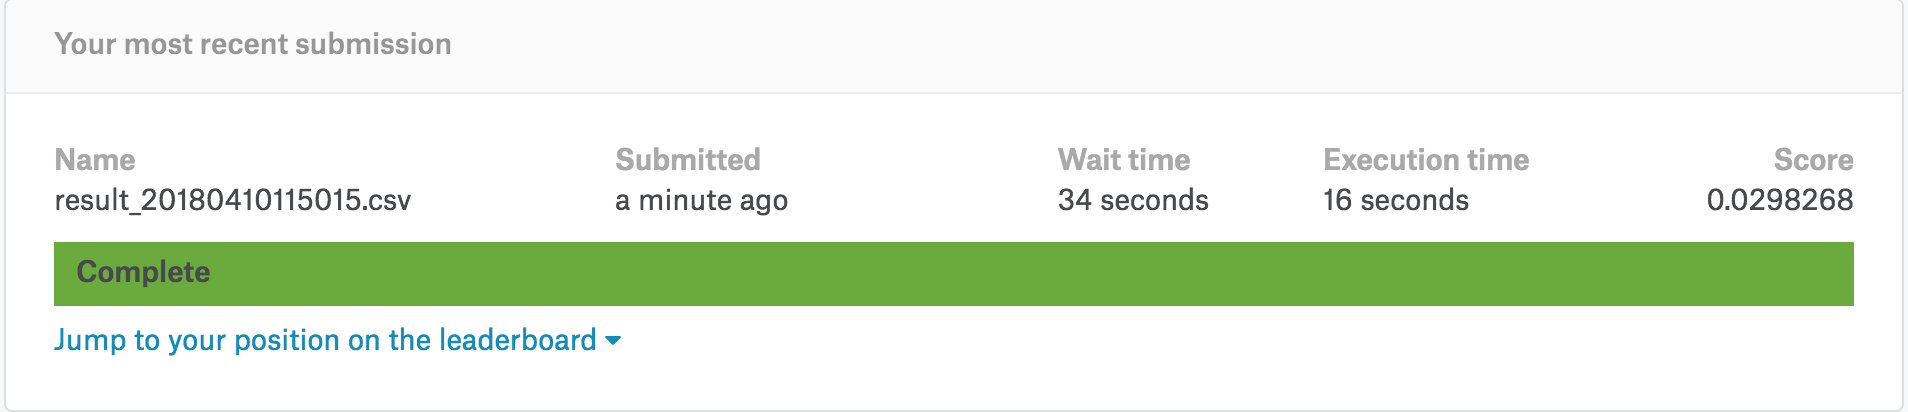

In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
from collections import defaultdict
import xgboost as xgb
%matplotlib inline
import warnings
from tqdm import tqdm
import os

from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

color = sns.color_palette()

pd.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')



In [83]:
cat_col = ['fecha_dato', 'ncodpers','ind_empleado','pais_residencia','sexo','age','fecha_alta','ind_nuevo','antiguedad','indrel', 'indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','canal_entrada','indfall', 'tipodom','cod_prov','ind_actividad_cliente','renta','segmento']

notuse = ["ult_fec_cli_1t","nomprov"]

product_col = [
'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1',
'ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1',
'ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1',
'ind_nom_pens_ult1','ind_recibo_ult1']

product_col = product_col[2:]

train_cols = cat_col + product_col

In [84]:
df_train = pd.read_csv('./data/all_clean.csv', usecols = train_cols)

In [85]:
df_test = pd.read_csv('./data/test_ver2.csv')

# 1. 변수 설명

### feature 24개

- fecha_dato : The table is partitioned for this column

- ncodpers : Customer code

- ind_empleado : Employee index A : active, B : ex-employed, F : filial, N : not employee, P : pasive #직원 여부

- pais_residencia : Customer's Country residence #거주지

- sexo : Customer's sex #성별

- age : Age #나이

- fecha_alta : The date in which the customer became as the first holder of a contract in the bank #처음 가입 날짜

- ind_nuevo : New customer Index. 1 if the customer registered in the last 6 months. #최근 6개월 가입 여부(신규가입자)

- antiguedad : Customer seniority (in months) #유지 개월 수

- indrel : 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month) #주고객층 여부

- ult_fec_cli_1t : Last date as primary customer (if he isn't at the end of the month) #주고객층이었던 마지막 날짜

- indrel_1mes : Customer type at the beginning of the month ,1 (First/Primary customer), 2 (co-owner),P (Potential),3 (former primary), 4(former co-owner) #고객 타입(주고객, 공동소유자, 잠재고객, 이전 주고객, 이전 공동소유자)

- tiprel_1mes : Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential) #월초 고객 타입

- indresi : Residence index (S (Yes) or N (No) if the residence country is the same than the bank country) #거주지 인덱스 : 거주 국가와 은행 국가의 일치 여부

- indext : Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country) #외국인 인덱스 : 출생 국가와 은행 국가의 일치 여부

- conyuemp : Spouse index. 1 if the customer is spouse of an employee #배우자 인덱스 : 직원의 배우자인 경우

- canal_entrada : channel used by the customer to join #가입한 채널

- indfall : Deceased index. N/S #사망 여부

- tipodom : Addres type. 1, primary address #주소 타입 : 1일 경우 주요 주소

- cod_prov : Province code (customer's address) #거주지 지역 코드

- nomprov : Province name #지역 이름

- ind_actividad_cliente : Activity index (1, active customer; 0, inactive customer) #활동 인덱스 : 1, 0

- renta : Gross income of the household #총 수입

- segmento : segmentation: 01 - VIP, 02 - Individuals 03 - college graduated #구분 : VIP / 개인 / 대학졸업자

### Class 24개

- ind_ahor_fin_ult1 : Saving Account #저축통장
- ind_aval_fin_ult1 : Guarantees #보증
- ind_cco_fin_ult1 : Current Accounts #예금
- ind_cder_fin_ult1 : Derivada Account #파생계좌
- ind_cno_fin_ult1	Payroll Account #월급통장
- ind_ctju_fin_ult1 : Junior Account #어린이계좌
- ind_ctma_fin_ult1	: Más particular Account #특별계좌1
- ind_ctop_fin_ult1 : particular Account #특별계좌2
- ind_ctpp_fin_ult1 : particular Plus Account #특별계좌3
- ind_deco_fin_ult1 : Short-term deposits #단기예금
- ind_deme_fin_ult1 : Medium-term deposits #중기예금
- ind_dela_fin_ult1 : Long-term deposits #장기예금
- ind_ecue_fin_ult1	: e-account #온라인계좌
- ind_fond_fin_ult1	: Funds #펀드
- ind_hip_fin_ult1 : Mortgage #담보대출
- ind_plan_fin_ult1 : Pensions #연금 
- ind_pres_fin_ult1 : Loans #대출
- ind_reca_fin_ult1 : Taxes #세금 
- ind_tjcr_fin_ult1 : Credit Card #신용카드
- ind_valo_fin_ult1 : Securities #증권
- ind_viv_fin_ult1 : Home Account #내집마련계좌
- ind_nomina_ult1 : Payroll #월급
- ind_nom_pens_ult1 : Pensions #연금
- ind_recibo_ult1 : Direct Debit #자동이체

In [86]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 20,
          'figure.figsize': (15, 5),
         'axes.labelsize': 25,
         'axes.titlesize': 30,
         'xtick.labelsize': 25,
         'ytick.labelsize': 25}
pylab.rcParams.update(params)

### 1-1. age(나이)

Text(0,0.5,'Number of customers')

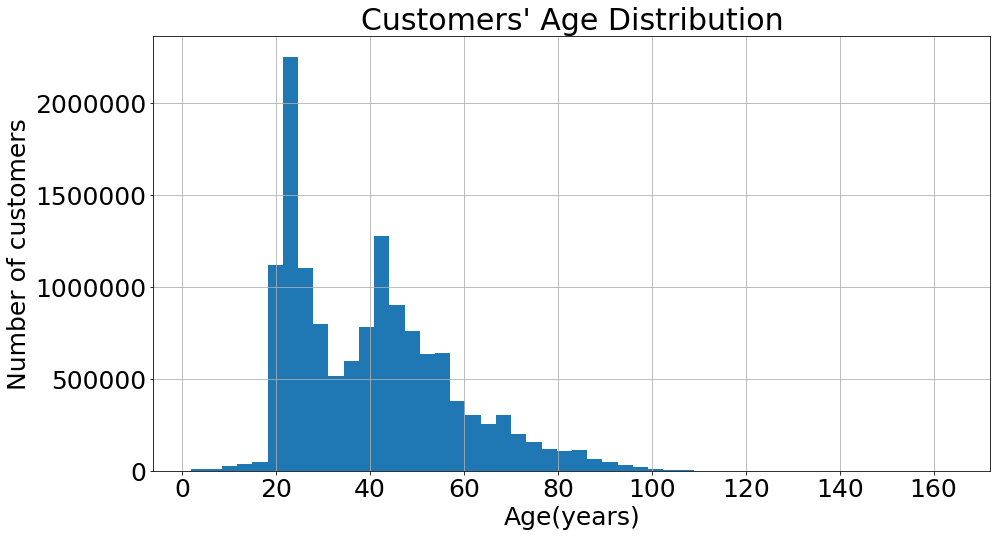

In [87]:
plt.figure(figsize=(15,8))
df_train['age'].hist(bins=50)
plt.title("Customers' Age Distribution")
plt.xlabel("Age(years)")
plt.ylabel("Number of customers")

In [88]:
df_train["age"]   = pd.to_numeric(df_train["age"], errors="coerce")
df_test["age"]   = pd.to_numeric(df_test["age"], errors="coerce")

age_group = [[0,19],[19,26],[26,36],[36,41],[41,47],[47,55],[55,60],[60,70],[70,80],[80,170]]

def create_age_group(df):  
   df['age_group'] = np.nan
   for i,age in enumerate(age_group):
       row_index = (df['age'] >= age[0]) & (df['age'] < age[1])
       df.loc[row_index,'age_group'] = i
       
create_age_group(df_train)
create_age_group(df_test)

# df_train.drop('age', axis=1, inplace = True)
# df_test.drop('age', axis=1, inplace = True)

Text(0,0.5,'Number of customers')

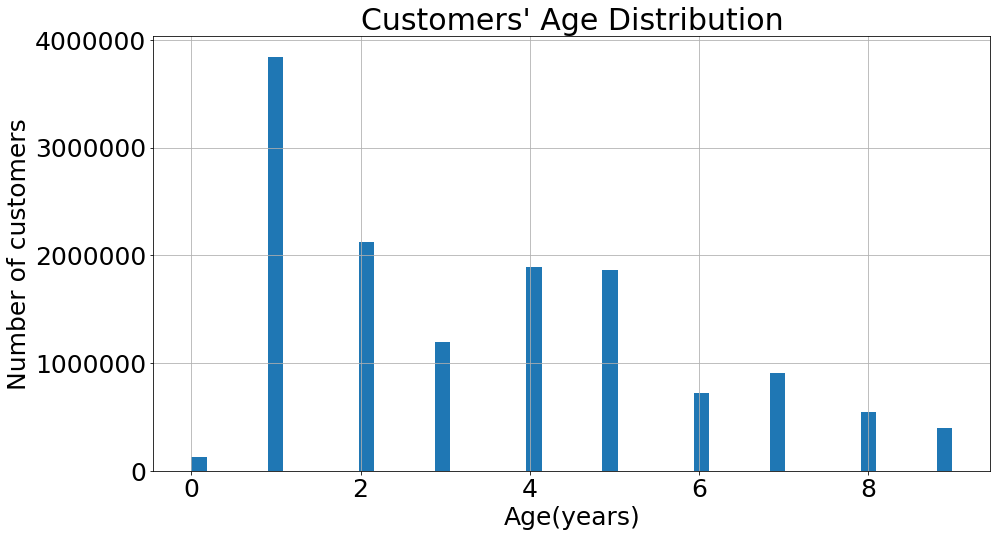

In [89]:
plt.figure(figsize=(15,8))
df_train['age_group'].hist(bins=50)
plt.title("Customers' Age Distribution")
plt.xlabel("Age(years)")
plt.ylabel("Number of customers")

In [90]:
df_age = (df_train.groupby(pd.cut(df_train['age'], [0,19,26,36,47,55,60,70,80,170], right=False)).sum())
df_age = df_age.loc[:, "ind_cco_fin_ult1":"ind_recibo_ult1"]
df_age = df_age.T
df_age

age,"[0, 19)","[19, 26)","[26, 36)","[36, 47)","[47, 55)","[55, 60)","[60, 70)","[70, 80)","[80, 170)"
ind_cco_fin_ult1,95.0,3122638.0,1535315.0,1775428.0,1059397.0,415025.0,517057.0,305896.0,207299.0
ind_cder_fin_ult1,0.0,3.0,99.0,2058.0,1504.0,508.0,660.0,370.0,170.0
ind_cno_fin_ult1,0.0,69116.0,202207.0,402551.0,242153.0,76577.0,69524.0,27682.0,13206.0
ind_ctju_fin_ult1,117643.0,11355.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0
ind_ctma_fin_ult1,1.0,3935.0,21021.0,53934.0,22931.0,9105.0,11560.0,6232.0,3538.0
ind_ctop_fin_ult1,0.0,14546.0,61717.0,564421.0,427805.0,167717.0,217084.0,162705.0,143388.0
ind_ctpp_fin_ult1,0.0,1278.0,36720.0,245464.0,150466.0,52015.0,57610.0,29502.0,17600.0
ind_deco_fin_ult1,0.0,389.0,2975.0,9193.0,5001.0,1918.0,2443.0,1144.0,770.0
ind_deme_fin_ult1,0.0,70.0,1011.0,7806.0,6428.0,2411.0,2174.0,1422.0,1341.0
ind_dela_fin_ult1,246.0,4364.0,24362.0,161765.0,150052.0,64574.0,85132.0,57359.0,38362.0


In [91]:
exclude = ['ind_cco_fin_ult1']
df_age = df_age.T
df_age = df_age.drop(exclude, axis=1).T

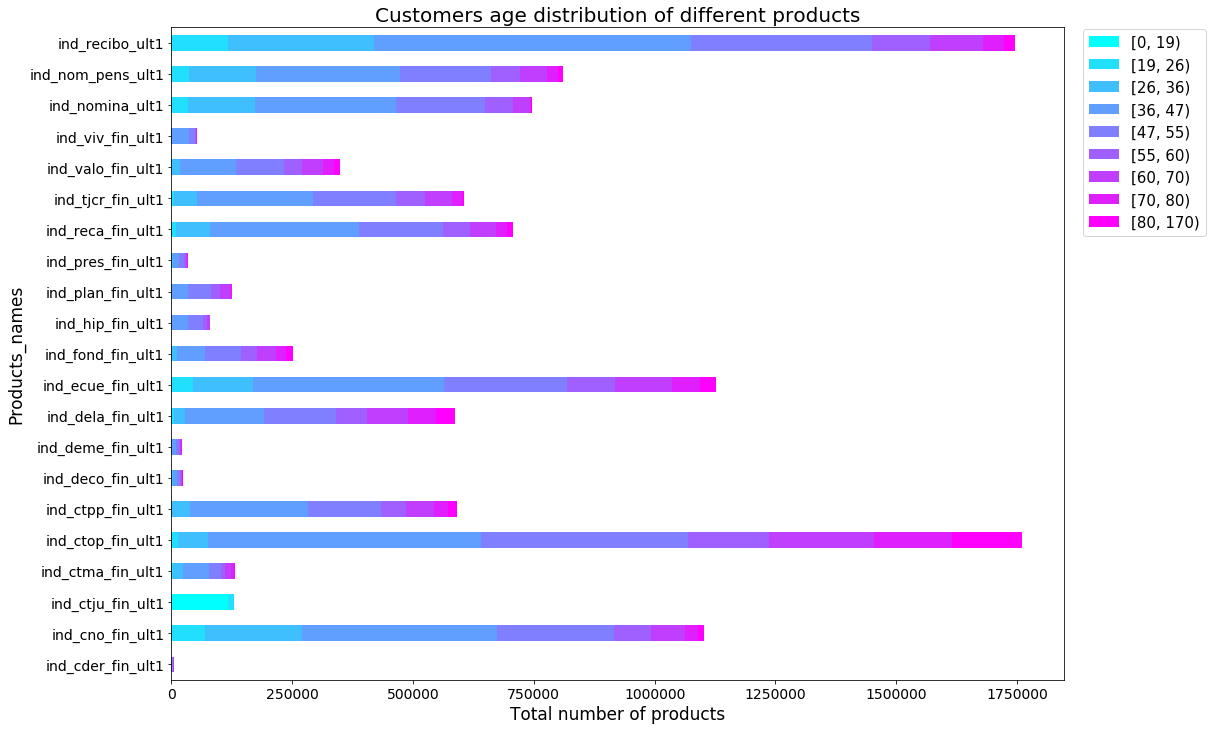

In [92]:
df_age.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='cool')
plt.title('Customers age distribution of different products', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.1, prop={'size':15}) 

### 1-2. antiguedad(유지 개월 수)

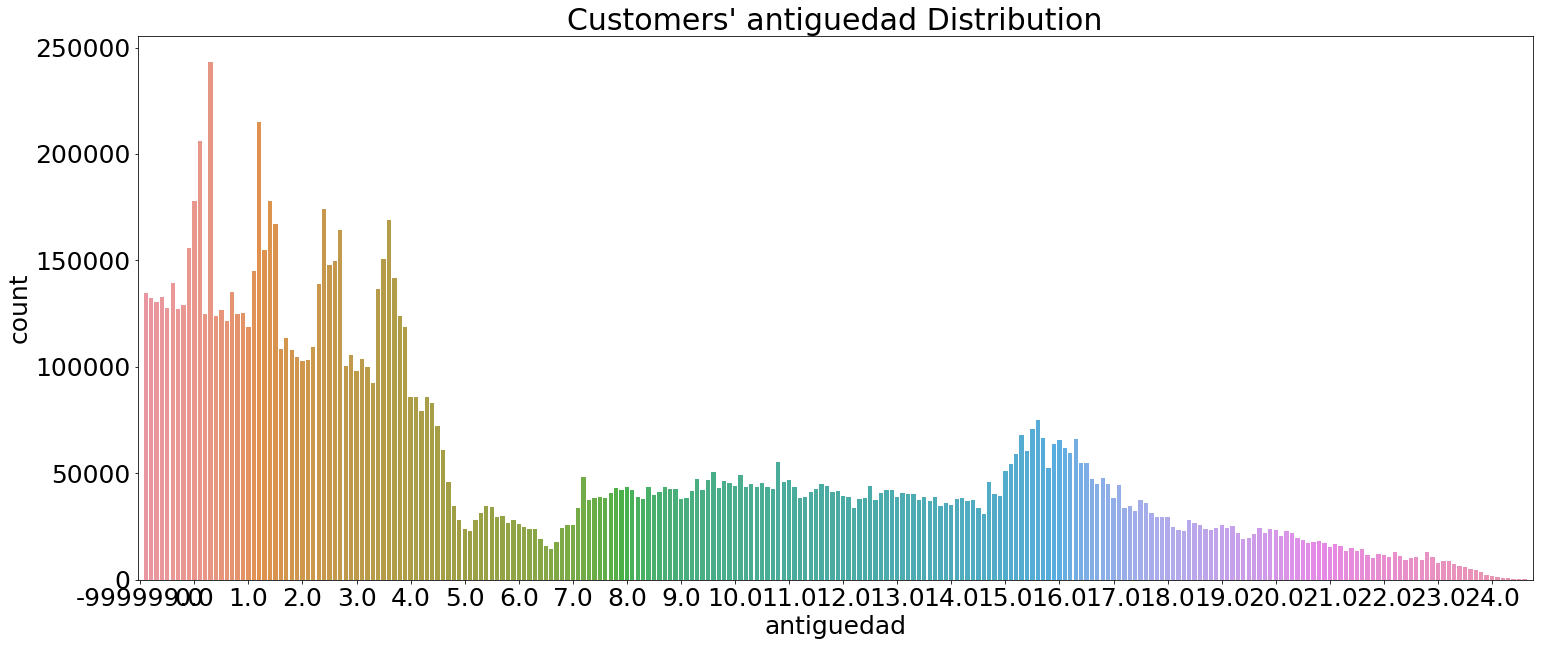

In [93]:
plt.figure(figsize=(25,10))
sns.countplot(x='antiguedad', data=df_train)
plt.title("Customers' antiguedad Distribution")
plt.xticks(np.arange(0, 256, 10))
plt.show()

### 1-3. ind_actividad_clients(활동 고객 여부)

Text(0.5,1,'ind_actividad_cliente')

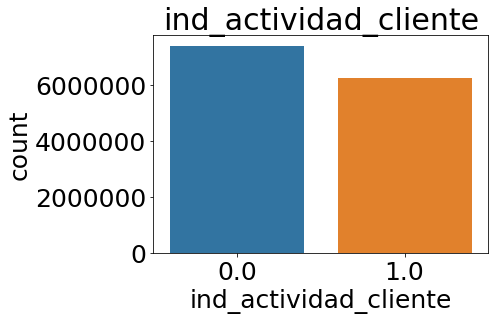

In [94]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x='ind_actividad_cliente', data=df_train, order=df_train['ind_actividad_cliente'].value_counts().index)
plt.title('ind_actividad_cliente', fontsize=30, color='black')

### 1-4. renta(수입)

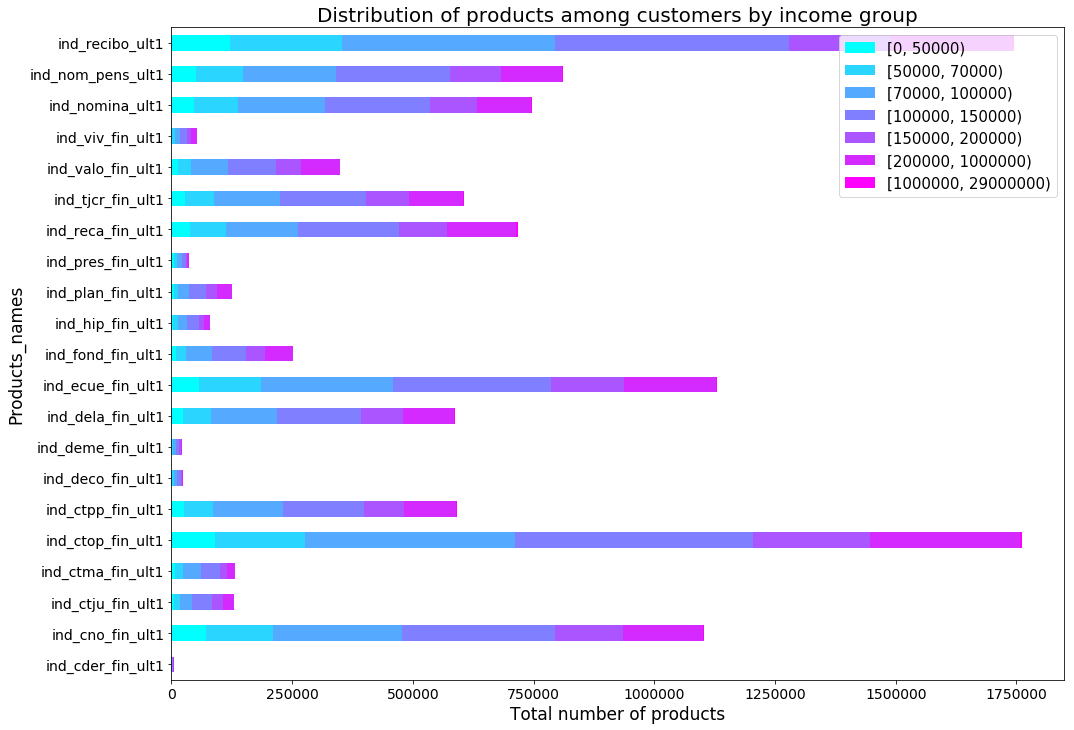

In [95]:
df_test["renta"]   = pd.to_numeric(df_test["renta"], errors="coerce")
unique_prov = df_test[df_test.cod_prov.notnull()].cod_prov.unique()
grouped = df_test.groupby("cod_prov")["renta"].median()

def impute_renta(df):
    df["renta"]   = pd.to_numeric(df["renta"], errors="coerce")      
    for cod in unique_prov:
        df.loc[df['cod_prov']==cod,['renta']] = df.loc[df['cod_prov']==cod,['renta']].fillna({'renta':grouped[cod]}).values
    df.renta.fillna(df_test["renta"].median(), inplace=True)
   
impute_renta(df_train)
impute_renta(df_test)

renta_group = [[0,50000],[50000,70000],[70000,100000],[100000,150000],[150000,200000],[200000,1000000],[1000000,29000000]]

def create_renta_group(df):  
    df['renta_group'] = np.nan
    for i,renta in enumerate(renta_group):
        row_index = (df['renta'] >= renta[0]) & (df['renta'] < renta[1])
        df.loc[row_index,'renta_group'] = i
         
create_renta_group(df_train)
create_renta_group(df_test)


df_renta = (df_train.groupby(pd.cut(df_train['renta'], [0,50000,70000,100000,150000,200000,1000000,29000000], right=False)).sum())
df_renta = df_renta.loc[:, "ind_cco_fin_ult1": "ind_recibo_ult1"]
df_renta = df_renta.T

exclude = ['ind_cco_fin_ult1']
df_renta = df_renta.T
df_renta = df_renta.drop(exclude, axis=1).T

df_renta.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='cool')
plt.title('Distribution of products among customers by income group', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]), <a list of 52 Text xticklabel objects>)

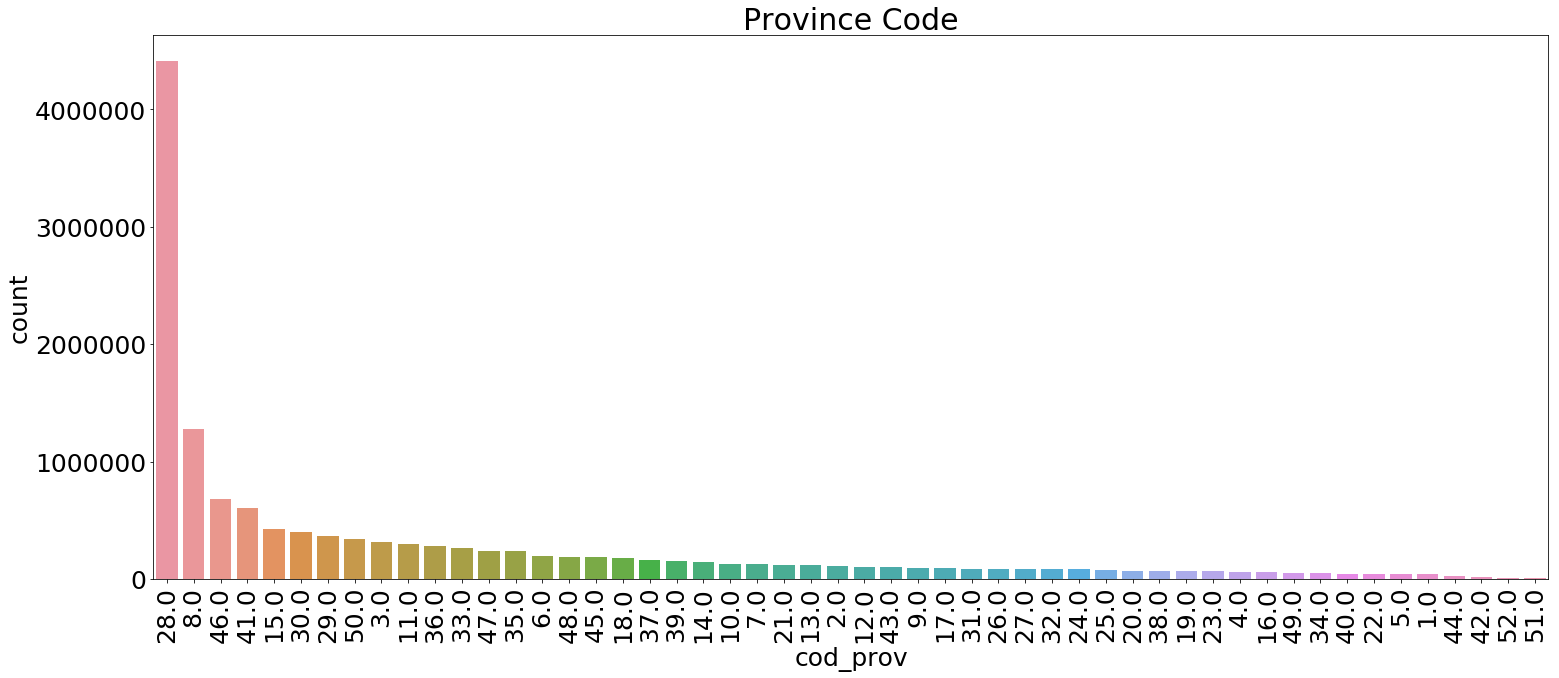

In [96]:
plt.figure(figsize=(25,10))
ax = sns.countplot(x='cod_prov', data=df_train, order=df_train['cod_prov'].value_counts().index)
plt.title('Province Code', fontsize=30, color='black')
plt.xticks(rotation=90)

In [97]:
train = pd.read_csv("./data/train_ver2.csv", usecols=['fecha_dato', 'fecha_alta'], parse_dates=['fecha_dato', 'fecha_alta'])
train['fecha_alta_yearmonth'] = train['fecha_alta'].apply(lambda x: (100*x.year) + x.month)

In [267]:
a = pd.date_range("2018-4-1", "2018-12-31", freq="M")
type(a)

pandas.core.indexes.datetimes.DatetimeIndex

In [270]:
yearmonth = train['fecha_alta_yearmonth'].value_counts()
year_month = yearmonth.sort_index().reset_index()
year_month = year_month.ix[185:]
year_month.columns = ['yearmonth', 'number_of_customers']
plt.figure(figsize=(12,4), xticks = a.to_pydatetime())
sns.barplot(year_month.yearmonth.astype('int'), year_month.number_of_customers, alpha=0.8, color=color[2])
plt.xlabel('yearmonth', fontsize = 0.5, color='black')
plt.ylabel('number_of_customers', fontsize = 0.5, color='black')
plt.xticks(rotation='vertical' )
plt.show()

TypeError: __init__() got an unexpected keyword argument 'xticks'

# Model 1

In [99]:
cat_col = ['fecha_dato', 'ncodpers','ind_empleado','pais_residencia','sexo','age','fecha_alta','ind_nuevo','antiguedad','indrel', 'indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','canal_entrada','indfall', 'tipodom','cod_prov','ind_actividad_cliente','renta','segmento']

notuse = ["ult_fec_cli_1t","nomprov"]

product_col = [
 'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1',
 'ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1',
 'ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1',
 'ind_nom_pens_ult1','ind_recibo_ult1']

product_col = product_col[2:]

train_cols = cat_col + product_col

In [100]:
df_train = pd.read_csv('./data/train_ver2.csv',usecols=train_cols)
df_train['fecha_dato'] = pd.to_datetime(df_train['fecha_dato'], format='%Y-%m-%d', errors='ignore')

In [101]:
month = 6

df_train_curr = df_train.loc[df_train['fecha_dato']=='2015-06-28',:]
df_train_5 = df_train.loc[df_train['fecha_dato']=='2015-05-28', product_col+['ncodpers']]
df_train_4 = df_train.loc[df_train['fecha_dato']=='2015-04-28', product_col+['ncodpers']]
df_train_3 = df_train.loc[df_train['fecha_dato']=='2015-03-28', product_col+['ncodpers']]
df_train_2 = df_train.loc[df_train['fecha_dato']=='2015-02-28', product_col+['ncodpers']]
df_train_1 = df_train.loc[df_train['fecha_dato']=='2015-01-28', product_col+['ncodpers']]

In [102]:
dfm = pd.merge(df_train_curr,df_train_5, how='left', on=['ncodpers'], suffixes=('', '_5'))
dfm = pd.merge(dfm,df_train_4, how='left', on=['ncodpers'], suffixes=('', '_4'))
dfm = pd.merge(dfm,df_train_3, how='left', on=['ncodpers'], suffixes=('', '_3'))
dfm = pd.merge(dfm,df_train_2, how='left', on=['ncodpers'], suffixes=('', '_2'))
dfm = pd.merge(dfm,df_train_1, how='left', on=['ncodpers'], suffixes=('', '_1'))

In [103]:
prevcols = [col for col in dfm.columns if '_ult1_'+str(month-1) in col]
currcols = [col for col in dfm.columns if '_ult1' == col[-5:]]

In [104]:
all_product_col = [col for col in dfm.columns if '_ult1' in col]

for col in all_product_col:
    dfm[col].fillna(0, inplace=True)

In [105]:
for col in currcols:
    dfm[col] = dfm[col] - dfm[col+'_'+str(month-1)]
    dfm[col] = dfm[col].apply(lambda x: max(x,0))

In [106]:
dfm = dfm[dfm[currcols].sum(axis=1) >0]

In [107]:
print(dfm[currcols].sum(axis = 1).value_counts())

1.0    29492
2.0     5641
3.0     1412
4.0      156
5.0        9
dtype: int64


In [108]:
dfm = dfm.reset_index(drop=True) 
print(dfm.shape)

(36710, 154)


In [111]:
data = []

for index, row in tqdm(dfm.iterrows()):
    if row[currcols].sum() > 0:
        for i,col in enumerate(currcols):
            if row[col] == 1:
                row['target'] = float(currcols.index(col))
                data.append(list(row))
                
df_new = pd.DataFrame(data, columns = list(dfm.columns.values) + ['target'])

36710it [01:06, 555.12it/s]


In [112]:
df_new.drop(currcols+['fecha_dato'], axis=1, inplace=True)

In [113]:
df_new.to_csv('./data/output/DataMulticlass.csv', index=False)

In [114]:
df_train = pd.read_csv('./data/train_ver2.csv',usecols=train_cols)
df_june = pd.read_csv('./data/test_ver2.csv',usecols = cat_col)

In [115]:
month = 6

df_train_5 = df_train.loc[df_train['fecha_dato']=='2016-05-28', product_col+['ncodpers']]
df_train_4 = df_train.loc[df_train['fecha_dato']=='2016-04-28', product_col+['ncodpers']]
df_train_3 = df_train.loc[df_train['fecha_dato']=='2016-03-28', product_col+['ncodpers']]
df_train_2 = df_train.loc[df_train['fecha_dato']=='2016-02-28', product_col+['ncodpers']]
df_train_1 = df_train.loc[df_train['fecha_dato']=='2016-01-28', product_col+['ncodpers']]

In [116]:
dfm = pd.merge(df_june,df_train_5, how='inner', on=['ncodpers'], suffixes=('', '_5'))
dfm = pd.merge(dfm,df_train_4, how='left', on=['ncodpers'], suffixes=('', '_4'))
dfm = pd.merge(dfm,df_train_3, how='left', on=['ncodpers'], suffixes=('', '_3'))
dfm = pd.merge(dfm,df_train_2, how='left', on=['ncodpers'], suffixes=('', '_2'))
dfm = pd.merge(dfm,df_train_1, how='left', on=['ncodpers'], suffixes=('', '_1'))

all_product_col = [col for col in dfm.columns if '_ult1' in col]

for col in all_product_col:
    dfm[col].fillna(0, inplace=True)

In [117]:
for col in product_col:
    dfm[col+'_5'] =dfm[col]
    
dfm.drop(product_col, axis=1, inplace=True)

dfm.drop('fecha_dato', axis=1, inplace=True)
dfm.to_csv('./data/output/TestSet.csv', index=False)

In [118]:
demographic_cols = ['ncodpers','fecha_alta','ind_empleado','pais_residencia','sexo','age','ind_nuevo','antiguedad','indrel',
 'indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','canal_entrada','indfall',
 'tipodom','cod_prov','ind_actividad_cliente','renta','segmento']

notuse = ["ult_fec_cli_1t","nomprov",'fecha_dato']

product_col = [
 'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1',
 'ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1',
 'ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1',
 'ind_nom_pens_ult1','ind_recibo_ult1']

In [169]:
df_train = pd.read_csv('./data/output/DataMulticlass.csv')
df_test = pd.read_csv('./data/output/TestSet.csv')

In [170]:
def filter_data(df):
    df = df[df['ind_nuevo'] == 0]
    df = df[df['antiguedad'] != -999999]
    df = df[df['indrel'] == 1]
    df = df[df['indresi'] == 'S']
    df = df[df['indfall'] == 'N']
    df = df[df['tipodom'] == 1]
    df = df[df['ind_empleado'] == ('N' or 'A' )]
    df = df[df['pais_residencia'] == 'ES']
    df = df[df['indrel_1mes'] == 1]
    df = df[df['tiprel_1mes'] == ('A' or 'I')]
    df = df[df['indext'] == 'N']

In [171]:
drop_column = ['ind_nuevo','indrel','indresi','indfall','tipodom','ind_empleado','pais_residencia','indrel_1mes','indext','conyuemp','fecha_alta','tiprel_1mes']

df_train.drop(drop_column, axis=1, inplace = True)
df_test.drop(drop_column, axis=1, inplace = True)

In [172]:
for col in df_train.columns:
    df_train[col] = pd.to_numeric(df_train[col], errors="coerce")
    
for col in df_test.columns:
    df_test[col] = pd.to_numeric(df_test[col], errors="coerce")

In [173]:
df_train["age"]   = pd.to_numeric(df_train["age"], errors="coerce")
df_test["age"]   = pd.to_numeric(df_test["age"], errors="coerce")

age_group = [[0,19],[19,26],[26,36],[36,41],[41,47],[47,55],[55,60],[60,70],[70,80],[80,170]]

def create_age_group(df):  
    df['age_group'] = np.nan
    for i,age in enumerate(age_group):
        row_index = (df['age'] >= age[0]) & (df['age'] < age[1])
        df.loc[row_index,'age_group'] = i
       
create_age_group(df_train)
create_age_group(df_test)

df_train.drop('age', axis=1, inplace = True)
df_test.drop('age', axis=1, inplace = True)

In [174]:
df_train['age_group'].value_counts()

2.0    9457
4.0    8898
5.0    7845
3.0    6146
1.0    4456
7.0    3249
6.0    2632
8.0    1958
9.0     970
0.0      60
Name: age_group, dtype: int64

In [175]:
def drop_na(df):
    df.dropna(axis = 0, subset = ['ind_actividad_cliente'], inplace = True)
    
drop_na(df_train)

In [176]:
dummy_col = ['sexo','canal_entrada','cod_prov','segmento']
dummy_col_select = ['sexo','canal_entrada','cod_prov','segmento']

In [177]:
limit = int(0.05 * len(df_train.index))
use_dummy_col = {}

for col in dummy_col_select:
    trainlist = df_train[col].value_counts()
    use_dummy_col[col] = []
    for i,item in enumerate(trainlist):
        if item > limit:
            use_dummy_col[col].append(df_train[col].value_counts().index[i])

In [178]:
def get_dummy(df):
    for col in dummy_col_select:
        for item in df[col].unique(): 
            if item not in use_dummy_col[col]:
                row_index = df[col] == item
                df.loc[row_index,col] = np.nan
    return pd.get_dummies(df, prefix=dummy_col, columns = dummy_col)
    
df_train = get_dummy(df_train)
df_test = get_dummy(df_test)

In [179]:
product_col_5 = [col for col in df_train.columns if '_ult1_5' in col]
product_col_4 = [col for col in df_train.columns if '_ult1_4' in col]
product_col_3 = [col for col in df_train.columns if '_ult1_3' in col]
product_col_2 = [col for col in df_train.columns if '_ult1_2' in col]
product_col_1 = [col for col in df_train.columns if '_ult1_1' in col]

df_train['tot'] = df_train[product_col_5].sum(axis=1)
df_test['tot'] = df_test[product_col_5].sum(axis=1)

In [217]:
def runXGB(train_X, train_y, colsample_bytree=0.9, max_depth= 6, eta=0.1, min_child_weight=2, subsample=0.9, num_rounds=100):
    param = {}
    param['objective'] = 'multi:softprob'
    param['seed'] = 0
    param['silent'] = 0
    param['eval_metric'] = "mlogloss"
    param['booster'] = 'gbtree'
    param['num_class'] = 22
    param['reg_lambda'] =100
    param['colsample_bytree'] = colsample_bytree
    param['max_depth'] = max_depth 
    param['eta'] = eta
    param['min_child_weight'] = min_child_weight
    param['subsample'] = subsample
    num_round = num_rounds

    progress = dict()
    plst = list(param.items())
        
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    watchlist  = [(xgtrain,'train')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, evals_result=progress)
    return (model, progress, xgtrain)

In [218]:
cols = list(df_train.drop(['target','ncodpers'], 1).columns.values)

id_preds = defaultdict(list)
ids = df_test['ncodpers'].values

# predict model 
y_train = df_train['target']
x_train = df_train[cols]

(clf, progress, xgtrain) = runXGB(x_train, y_train)
          
x_test = df_test[cols]

xg_test = clf.predict(xgtrain)
        
d_test = xgb.DMatrix(x_test)
p_test = clf.predict(d_test)
  
for id, p in zip(ids, p_test):
    id_preds[id] = [0,0] + list(p)
    

[0]	train-mlogloss:2.71641
[1]	train-mlogloss:2.48134
[2]	train-mlogloss:2.31138
[3]	train-mlogloss:2.17444
[4]	train-mlogloss:2.06477
[5]	train-mlogloss:1.97169
[6]	train-mlogloss:1.88796
[7]	train-mlogloss:1.8139
[8]	train-mlogloss:1.74802
[9]	train-mlogloss:1.69054
[10]	train-mlogloss:1.63896
[11]	train-mlogloss:1.59417
[12]	train-mlogloss:1.55053
[13]	train-mlogloss:1.51159
[14]	train-mlogloss:1.47575
[15]	train-mlogloss:1.4437
[16]	train-mlogloss:1.41409
[17]	train-mlogloss:1.38721
[18]	train-mlogloss:1.3618
[19]	train-mlogloss:1.33893
[20]	train-mlogloss:1.3175
[21]	train-mlogloss:1.29742
[22]	train-mlogloss:1.27888
[23]	train-mlogloss:1.26202
[24]	train-mlogloss:1.24651
[25]	train-mlogloss:1.23169
[26]	train-mlogloss:1.21791
[27]	train-mlogloss:1.20507
[28]	train-mlogloss:1.19299
[29]	train-mlogloss:1.18174
[30]	train-mlogloss:1.17115
[31]	train-mlogloss:1.16126
[32]	train-mlogloss:1.15203
[33]	train-mlogloss:1.14359
[34]	train-mlogloss:1.13529
[35]	train-mlogloss:1.12763
[36]	t

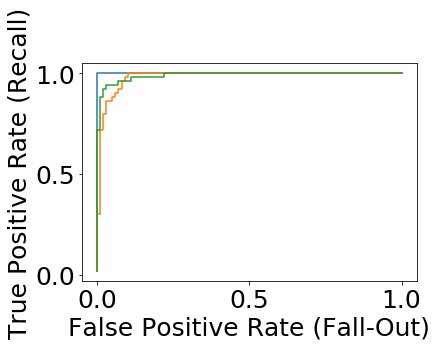

In [302]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_iris
from sklearn.preprocessing import label_binarize

iris = load_iris()
X = iris.data
y = label_binarize(iris.target, [0, 1, 2])

fpr = [None] * 3
tpr = [None] * 3
thr = [None] * 3

for i in range(3):
    model = GaussianNB().fit(X, y[:, i])
    fpr[i], tpr[i], thr[i] = roc_curve(y[:, i], model.predict_proba(X)[:, 1])
    plt.plot(fpr[i], tpr[i])

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [283]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve

X = x_train
y = label_binarize(y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

X.fillna(X.median(), inplace=True)

fpr = [None] * 22
tpr = [None] * 22
thr = [None] * 22

In [284]:
for i in range(22):
    fpr[i], tpr[i], thr[i] = roc_curve(y[:, i], clf.predict(xgtrain)[:, 1])
    print(auc(fpr[i], tpr[i]))

0.4446060958660095
0.912884041678225
0.5759784872344635
0.6492689965243456
0.7082471254085222
0.6920354643626883
0.6846059228905198
0.6517196854297522
0.7932600690280693
0.7488654246822947
0.4324272554141596
0.8092615810032618
0.8424847263888584
0.7858405048766494
0.8211859163874471
0.7423955626899983
0.4849565738489741
0.7953305009888885
0.6338209103383843
0.5681414312009045
0.395460553939249
0.43275153476589917


In [184]:
df_recent = pd.read_csv('./data/train_ver2.csv',usecols=['ncodpers'] + product_col)
df_recent = df_recent.drop_duplicates(['ncodpers'], keep='last')
sample = pd.read_csv('./data/sample_submission.csv')

In [185]:
already_active = {}
for row in df_recent.values:
    row = list(row)
    id = row.pop(0)
    active = [c[0] for c in zip(tuple(product_col), row) if c[1] > 0]
    already_active[id] = active

train_preds = {}
for id, p in id_preds.items():
    preds = [i[0] for i in sorted([i for i in zip(tuple(product_col), p) if i[0] not in already_active[id]],
                                  key=lambda i:i [1], 
                                  reverse=True)[:7]]
    train_preds[id] = preds
    
test_preds = []
for row in sample.values:
    id = row[0]
    p = train_preds[id]
    test_preds.append(' '.join(p))

In [186]:
from datetime import datetime

sample['added_products'] = test_preds
file_name = datetime.now().strftime("result_%Y%m%d%H%M%S") + '.csv'
sample.to_csv(os.path.join('./output/',file_name), index=False)

# Model 2

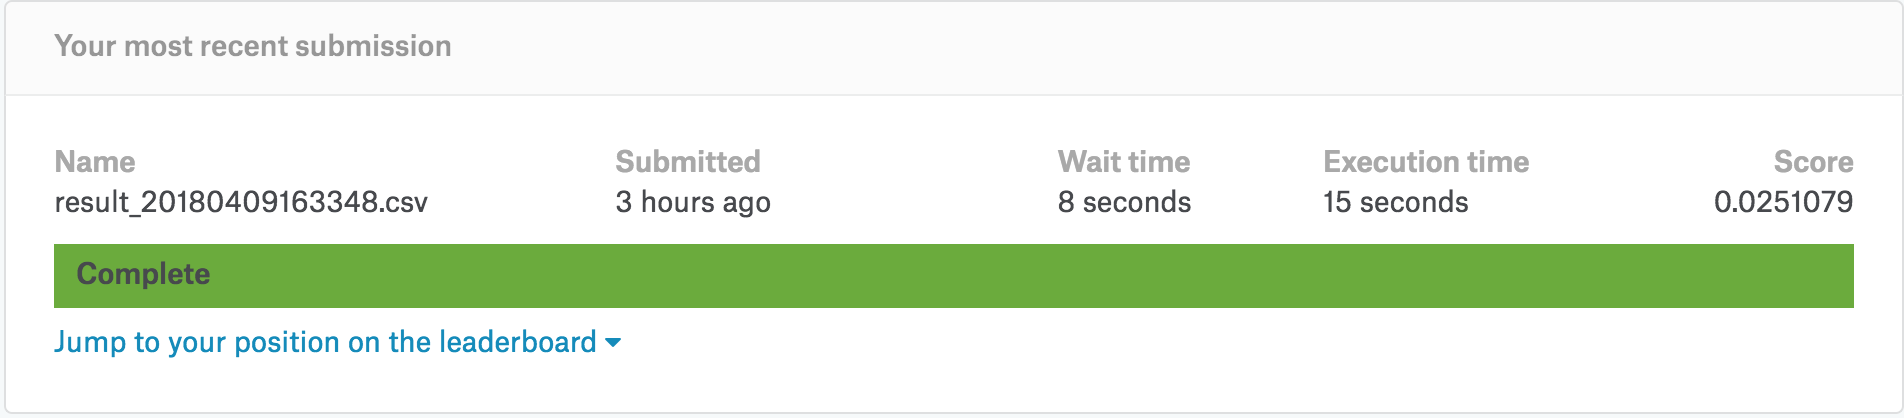

In [ ]:
month = 6

df_train_curr = df_train.loc[df_train['fecha_dato']=='2016-05-28',:]
df_train_5 = df_train.loc[df_train['fecha_dato']=='2016-04-28', product_col+['ncodpers']]
df_train_4 = df_train.loc[df_train['fecha_dato']=='2016-03-28', product_col+['ncodpers']]
df_train_3 = df_train.loc[df_train['fecha_dato']=='2016-02-28', product_col+['ncodpers']]
df_train_2 = df_train.loc[df_train['fecha_dato']=='2016-01-28', product_col+['ncodpers']]
df_train_1 = df_train.loc[df_train['fecha_dato']=='2015-12-28', product_col+['ncodpers']]

In [ ]:
dfm = pd.merge(df_train_curr,df_train_5, how='left', on=['ncodpers'], suffixes=('', '_5'))
dfm = pd.merge(dfm,df_train_4, how='left', on=['ncodpers'], suffixes=('', '_4'))
dfm = pd.merge(dfm,df_train_3, how='left', on=['ncodpers'], suffixes=('', '_3'))
dfm = pd.merge(dfm,df_train_2, how='left', on=['ncodpers'], suffixes=('', '_2'))
dfm = pd.merge(dfm,df_train_1, how='left', on=['ncodpers'], suffixes=('', '_1'))

In [ ]:
prevcols = [col for col in dfm.columns if '_ult1_'+str(month-1) in col]
currcols = [col for col in dfm.columns if '_ult1' == col[-5:]]

In [ ]:
all_product_col = [col for col in dfm.columns if '_ult1' in col]

for col in all_product_col:
    dfm[col].fillna(0, inplace=True)

In [ ]:
for col in currcols:
    dfm[col] = dfm[col] - dfm[col+'_'+str(month-1)]
    dfm[col] = dfm[col].apply(lambda x: max(x,0))

In [ ]:
dfm = dfm[dfm[currcols].sum(axis=1) >0]

In [ ]:
print(dfm[currcols].sum(axis = 1).value_counts())

In [ ]:
dfm = dfm.reset_index(drop=True) 
print(dfm.shape)

In [ ]:
data = []

for index, row in tqdm(dfm.iterrows()):
    if row[currcols].sum() > 0:
        for i,col in enumerate(currcols):
            if row[col] == 1:
                row['target'] = float(currcols.index(col))
                data.append(list(row))
                
df_new = pd.DataFrame(data, columns = list(dfm.columns.values) + ['target'])

In [ ]:
df_new.drop(currcols+['fecha_dato'], axis=1, inplace=True)

In [ ]:
df_new.to_csv('./data/output/DataMulticlass_1.csv', index=False)

In [ ]:
df_train = pd.read_csv('./data/train_ver2.csv',usecols=train_cols)
df_june = pd.read_csv('./data/test_ver2.csv',usecols = cat_col)

In [ ]:
month = 6

df_train_5 = df_train.loc[df_train['fecha_dato']=='2016-05-28', product_col+['ncodpers']]
df_train_4 = df_train.loc[df_train['fecha_dato']=='2016-04-28', product_col+['ncodpers']]
df_train_3 = df_train.loc[df_train['fecha_dato']=='2016-03-28', product_col+['ncodpers']]
df_train_2 = df_train.loc[df_train['fecha_dato']=='2016-02-28', product_col+['ncodpers']]
df_train_1 = df_train.loc[df_train['fecha_dato']=='2016-01-28', product_col+['ncodpers']]

In [ ]:
dfm = pd.merge(df_june,df_train_5, how='inner', on=['ncodpers'], suffixes=('', '_5'))
dfm = pd.merge(dfm,df_train_4, how='left', on=['ncodpers'], suffixes=('', '_4'))
dfm = pd.merge(dfm,df_train_3, how='left', on=['ncodpers'], suffixes=('', '_3'))
dfm = pd.merge(dfm,df_train_2, how='left', on=['ncodpers'], suffixes=('', '_2'))
dfm = pd.merge(dfm,df_train_1, how='left', on=['ncodpers'], suffixes=('', '_1'))

all_product_col = [col for col in dfm.columns if '_ult1' in col]

for col in all_product_col:
    dfm[col].fillna(0, inplace=True)

In [ ]:
for col in product_col:
    dfm[col+'_5'] =dfm[col]
    
dfm.drop(product_col, axis=1, inplace=True)

In [ ]:
dfm.drop('fecha_dato', axis=1, inplace=True)

In [ ]:
dfm.to_csv('./data/output/TestSet_1.csv', index=False)

In [ ]:
demographic_cols = ['ncodpers','fecha_alta','ind_empleado','pais_residencia','sexo','age','ind_nuevo','antiguedad','indrel',
 'indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','canal_entrada','indfall',
 'tipodom','cod_prov','ind_actividad_cliente','renta','segmento']

notuse = ["ult_fec_cli_1t","nomprov",'fecha_dato']

product_col = [
 'ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1',
 'ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1',
 'ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1',
 'ind_nom_pens_ult1','ind_recibo_ult1']

In [ ]:
df_train = pd.read_csv('./data/output/DataMulticlass_1.csv')
df_test = pd.read_csv('./data/output/TestSet_1.csv')

In [ ]:
def filter_data(df):
    df = df[df['ind_nuevo'] == 0]
    df = df[df['antiguedad'] != -999999]
    df = df[df['indrel'] == 1]
    df = df[df['indresi'] == 'S']
    df = df[df['indfall'] == 'N']
    df = df[df['tipodom'] == 1]
    df = df[df['ind_empleado'] == ('N' or 'A' )]
    df = df[df['pais_residencia'] == 'ES']
    df = df[df['indrel_1mes'] == 1]
    df = df[df['tiprel_1mes'] == ('A' or 'I')]
    df = df[df['indext'] == 'N']

In [ ]:
drop_column = ['ind_nuevo','indrel','indresi','indfall','tipodom','ind_empleado','pais_residencia','indrel_1mes','indext','conyuemp','fecha_alta','tiprel_1mes']

df_train.drop(drop_column, axis=1, inplace = True)
df_test.drop(drop_column, axis=1, inplace = True)

In [ ]:
for col in df_train.columns:
    df_train[col] = pd.to_numeric(df_train[col], errors="coerce")
    
for col in df_test.columns:
    df_test[col] = pd.to_numeric(df_test[col], errors="coerce")

In [ ]:
def drop_na(df):
    df.dropna(axis = 0, subset = ['ind_actividad_cliente'], inplace = True)
    
drop_na(df_train)

In [ ]:
dummy_col = ['sexo','canal_entrada','cod_prov','segmento']
dummy_col_select = ['canal_entrada','cod_prov']

In [ ]:
limit = int(0.05 * len(df_train.index))
use_dummy_col = {}

for col in dummy_col_select:
    trainlist = df_train[col].value_counts()
    use_dummy_col[col] = []
    for i,item in enumerate(trainlist):
        if item > limit:
            use_dummy_col[col].append(df_train[col].value_counts().index[i])

In [ ]:
def get_dummy(df):
    for col in dummy_col_select:
        for item in df[col].unique(): 
            if item not in use_dummy_col[col]:
                row_index = df[col] == item
                df.loc[row_index,col] = np.nan
    return pd.get_dummies(df, prefix=dummy_col, columns = dummy_col)
    
df_train = get_dummy(df_train)
df_test = get_dummy(df_test)

In [ ]:
product_col_5 = [col for col in df_train.columns if '_ult1_5' in col]
product_col_4 = [col for col in df_train.columns if '_ult1_4' in col]
product_col_3 = [col for col in df_train.columns if '_ult1_3' in col]
product_col_2 = [col for col in df_train.columns if '_ult1_2' in col]
product_col_1 = [col for col in df_train.columns if '_ult1_1' in col]

df_train['tot'] = df_train[product_col_5].sum(axis=1)
df_test['tot'] = df_test[product_col_5].sum(axis=1)

In [ ]:
def runXGB(train_X, train_y, colsample_bytree=0.9, max_depth= 6, eta=0.1, min_child_weight=2, subsample=0.9, num_rounds=100):
    param = {}
    param['objective'] = 'multi:softprob'
    param['seed'] = 0
    param['silent'] = 0
    param['eval_metric'] = "mlogloss"
    param['booster'] = 'gbtree'
    param['num_class'] = 22
    param['reg_lambda'] =100
    param['colsample_bytree'] = colsample_bytree
    param['max_depth'] = max_depth 
    param['eta'] = eta
    param['min_child_weight'] = min_child_weight
    param['subsample'] = subsample
    num_round = num_rounds

    progress = dict()
    plst = list(param.items())
        
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    watchlist  = [(xgtrain,'train')]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, evals_result=progress)
    return (model, progress)

In [ ]:
cols = list(df_train.drop(['target','ncodpers'], 1).columns.values)

id_preds = defaultdict(list)
ids = df_test['ncodpers'].values

# predict model 
y_train = df_train['target']
x_train = df_train[cols]

(clf, progress) = runXGB(x_train, y_train)
          
x_test = df_test[cols]
        
d_test = xgb.DMatrix(x_test)
p_test = clf.predict(d_test)
  
for id, p in zip(ids, p_test):
    id_preds[id] = [0,0] + list(p)
    

In [ ]:
df_recent = pd.read_csv('./data/train_ver2.csv',usecols=['ncodpers'] + product_col)
df_recent = df_recent.drop_duplicates(['ncodpers'], keep='last')

In [ ]:
sample = pd.read_csv('./data/sample_submission.csv')

In [ ]:
# check if customer already have each product or not. 
already_active = {}
for row in df_recent.values:
    row = list(row)
    id = row.pop(0)
    active = [c[0] for c in zip(tuple(product_col), row) if c[1] > 0]
    already_active[id] = active

train_preds = {}
for id, p in id_preds.items():
    preds = [i[0] for i in sorted([i for i in zip(tuple(product_col), p) if i[0] not in already_active[id]],
                                  key=lambda i:i [1], 
                                  reverse=True)[:7]]
    train_preds[id] = preds
    
test_preds = []
for row in sample.values:
    id = row[0]
    p = train_preds[id]
    test_preds.append(' '.join(p))

In [ ]:
from datetime import datetime

sample['added_products'] = test_preds
file_name = datetime.now().strftime("result_%Y%m%d%H%M%S") + '.csv'
sample.to_csv(os.path.join('./output/',file_name), index=False)